## Loading Liberay and dataset

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix
import warnings
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings('ignore')

file_path = 'data/milestone_ii_dataset.csv'

print("Libraries loaded. Ready to process.")

Libraries loaded. Ready to process.


## Helper Function that will help clean up the data

def load_and_prep_data(file_path):
- Making sure date columns is in the same format and sort by country and strictly by time
- Create a prediction Targets 'target_3m', 'target_6m' 
- Example: get result from april 2008 and past the result to january 2008

def get_feature_cols(df, concepts, exclude_cols, strict=False)
- This function decides which columns are useful for the model and which should be ignored.

def impute_features(df, cols_to_impute)
- Forward Fill or Backward Fill for blank dat.

def evaluate_model(y_true, y_pred, y_prob, model_name)
- This function prints out the final grades for a single model run.
- Precision, Recall, ROC-AUC score, F1 score
- TP: Successfully predicted recessions.
- FN: Missed recessions (Dangerous!).
- FP: False alarms.

def analyze_recession_prevalence(df, year, target_col='pre_recession'):
- label covid 

def create_sequences(df, feature_cols, target_col, look_back=12):
- Create data for LSTM 

In [61]:
def load_and_prep_data(file_path):
    print("--- Loading Data & Creating Targets ---")
    try:
        df = pd.read_csv(file_path)
        print(f"File loaded: {file_path}")
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return pd.DataFrame()

    if 'date' not in df.columns:
        raise ValueError("Column 'date' not found.")

    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['country', 'date']).reset_index(drop=True)
    df['year'] = df['date'].dt.year
    
    df['oecd_rec'] = pd.to_numeric(df['oecd_rec'], errors='coerce').fillna(0).astype(int)
    print("Generating targets: 3-month and 6-month horizons...")
    df['target_3m'] = df.groupby('country')['oecd_rec'].shift(-3)
    df['target_6m'] = df.groupby('country')['oecd_rec'].shift(-6)
    
    if 'pre_recession' not in df.columns:
        df['pre_recession'] = 0 
        
    print(f"Data loaded: {len(df)} rows across {df['country'].nunique()} countries.")
    return df

def get_feature_cols(df, concepts, exclude_cols, strict=False):
    selected = []
    for col in df.columns:
        if col in exclude_cols: continue
        if any(c in col for c in concepts) or (not strict and df[col].isnull().mean() < 0.20):
            selected.append(col)
    return selected

def impute_features(df, cols_to_impute):
    df_out = df.copy()
    for col in cols_to_impute:
        if col in df_out.columns:
            df_out[col] = df_out.groupby('country')[col].ffill()
            df_out[col] = df_out.groupby('country')[col].bfill()
    return df_out

def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"\n--- {model_name} Evaluation ---")
    print(classification_report(y_true, y_pred, target_names=['Expansion', 'Recession']))
    
    roc = roc_auc_score(y_true, y_prob)
    p, r, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(r, p)
    f1 = f1_score(y_true, y_pred)
    
    print(f"ROC-AUC: {roc:.3f}")
    print(f"PR-AUC:  {pr_auc:.3f}")
    print(f"F1 Score: {f1:.3f}")
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"Confusion Matrix: TP={tp}, FN={fn}, FP={fp}, TN={tn}")

def run_cross_validation_analysis(X, y, countries, model, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    all_preds = []
    
    print(f"Starting Cross-Validation ({n_splits} splits)...")
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        countries_test = countries.iloc[test_idx].values
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        fold_df = pd.DataFrame({
            'country': countries_test,
            'y_true': y_test.values,
            'y_pred': y_pred,
            'y_proba': y_proba,
            'fold': fold + 1
        })
        all_preds.append(fold_df)
        
    return pd.concat(all_preds, ignore_index=True)

def print_country_metrics(pred_df):
    country_metrics = []
    for country in sorted(pred_df['country'].unique()):
        sub = pred_df[pred_df['country'] == country]
        if len(sub) == 0: continue
        
        try:
            auc_val = roc_auc_score(sub['y_true'], sub['y_proba']) if sub['y_true'].nunique() > 1 else np.nan
        except: auc_val = np.nan

        country_metrics.append({
            'Country': country,
            'Accuracy': accuracy_score(sub['y_true'], sub['y_pred']),
            'Precision': precision_score(sub['y_true'], sub['y_pred'], zero_division=0),
            'Recall': recall_score(sub['y_true'], sub['y_pred'], zero_division=0),
            'F1': f1_score(sub['y_true'], sub['y_pred'], zero_division=0),
            'ROC-AUC': auc_val,
            'Support': int(sub['y_true'].sum())
        })
    
    metrics_df = pd.DataFrame(country_metrics).set_index('Country')
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(metrics_df)
    
    print("\n" + "-"*80)
    print(f"Global Accuracy: {accuracy_score(pred_df['y_true'], pred_df['y_pred']):.3f}")
    print(f"Global Recall:   {recall_score(pred_df['y_true'], pred_df['y_pred']):.3f}")
    print(f"Global F1 Score: {f1_score(pred_df['y_true'], pred_df['y_pred']):.3f}")
    print(f"Global ROC-AUC:  {roc_auc_score(pred_df['y_true'], pred_df['y_proba']):.3f}")
    print("-" * 80)
    return metrics_df

def analyze_recession_prevalence(df, year, target_col='pre_recession'):
    """Analyzes recession labels for a specific year."""
    print(f"{year} Label Analysis (checking for contamination)...")
    
    if target_col not in df.columns:
        print(f"Column '{target_col}' not found. Skipping analysis.")
        return
    mask = df['year'] == year
    df_sub = df[mask]
    total = len(df_sub)

    if total == 0:
        print(f"No data found for year {year}.")
        return

    count = df_sub[target_col].sum()
    pct = (count / total) * 100

    print(f"Total {year} observations: {total}")
    print(f"Labeled as {target_col}=1: {count} ({pct:.1f}%)")
    
    if count > 0:
        print("Breakdown by Country:")
        print(df_sub.groupby('country')[target_col].agg(['sum', 'count']))
    else:
        print(f"No {target_col} events found in {year}.")

def create_sequences(df, feature_cols, target_col, look_back=12):
    Xs, ys, countries = [], [], []

    for country in df['country'].unique():
        sub = df[df['country'] == country].sort_values('date')
        data = sub[feature_cols].values
        target = sub[target_col].values

        if len(data) <= look_back: continue
        
        for i in range(len(data) - look_back):
            Xs.append(data[i:(i + look_back)])
            ys.append(target[i + look_back])
            countries.append(country)
            
    return np.array(Xs), np.array(ys), np.array(countries)

In [43]:
file_path = 'data/milestone_ii_dataset.csv'
df_raw = load_and_prep_data(file_path)

--- Loading Data & Creating Targets ---
File loaded: data/milestone_ii_dataset.csv
Generating targets: 3-month and 6-month horizons...
Data loaded: 5508 rows across 9 countries.


## Building the baseline  - Logistic Regression

- This will select the most related features and help us to filter blank data since Logistic Regression is bad handle with datasets that contain missing data.

### Tier 1 dataset this only contain indicator that appear in the 1970s
- I drop out some features that has atleast 20% or more that is missing
- Indicated such as VIX was created after 1993 so I also remove that for this section.

### Result

- Accurcay 66% 
- Precesion 60%
- Recall 25%
- ROC-AUC 63.6% 

In [62]:
if not df_raw.empty:
    exclude_cols = ['date', 'country', 'target_3m', 'target_6m', 'oecd_rec', 
                    'technical_rec', 'pre_recession', 'gdp_qoq_growth', 'year']
    SPLIT_DATE = '2005-01-01'

    print("\n" + "="*40)
    print("PART 1: Logistic Regression (Tier 1 Only)")
    print("="*40)
    
    tier_1_concepts = ['10_yr_yld', '3_mo_yld', 'yield_curve', 'real_gdp', 'ind_out', 
                       'retail_vol', 'pcar_reg', 'unemployment', 'sahm', 'cpi', 
                       'oil', 'copper', 'national_share_price']
    
    feat_lr = get_feature_cols(df_raw, tier_1_concepts, exclude_cols)
    print(f"Tier 1 Features selected: {len(feat_lr)}")
    
    df_lr = df_raw[['date', 'country', 'target_3m'] + feat_lr].copy()
    df_lr.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_lr = df_lr.dropna(subset=['target_3m'])
    df_lr['target_3m'] = df_lr['target_3m'].astype(int)
    
    print("Imputing values...")
    df_lr = impute_features(df_lr, feat_lr)
    df_lr = df_lr.dropna()
    
    train_lr = df_lr[df_lr['date'] < SPLIT_DATE]
    test_lr = df_lr[df_lr['date'] >= SPLIT_DATE]
    
    scaler = StandardScaler()
    X_train_lr = scaler.fit_transform(train_lr[feat_lr])
    X_test_lr = scaler.transform(test_lr[feat_lr])
    
    print("Training Logistic Regression...")
    model_lr = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', class_weight='balanced', random_state=42)
    model_lr.fit(X_train_lr, train_lr['target_3m'])
    
    evaluate_model(test_lr['target_3m'], model_lr.predict(X_test_lr), 
                   model_lr.predict_proba(X_test_lr)[:, 1], "Logistic Regression")
    
    coeffs = pd.DataFrame({'Feature': feat_lr, 'Coef': model_lr.coef_[0], 'Abs': np.abs(model_lr.coef_[0])})
    print("\nTop 5 Indicators (LR):")
    print(coeffs.sort_values('Abs', ascending=False).head(5))


PART 1: Logistic Regression (Tier 1 Only)
Tier 1 Features selected: 173
Imputing values...
Training Logistic Regression...

--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

   Expansion       0.68      0.90      0.77      1079
   Recession       0.60      0.25      0.35       622

    accuracy                           0.66      1701
   macro avg       0.64      0.58      0.56      1701
weighted avg       0.65      0.66      0.62      1701

ROC-AUC: 0.636
PR-AUC:  0.496
F1 Score: 0.351
Confusion Matrix: TP=155, FN=467, FP=105, TN=974

Top 5 Indicators (LR):
                          Feature      Coef       Abs
60                   cli_diff_1mo -1.469159  1.469159
46   comp_consumer_conf_diff_12mo -0.459075  0.459075
100              ind_out_lag_12mo  0.394213  0.394213
152           sahm_value_lag_12mo -0.353119  0.353119
63                  cli_diff_12mo -0.334268  0.334268


## Tier 2 data and basic XGboost

- Use features such as VIX and EPU without filtering such as NaN with the Teir 1 dataset
- 'NaN' data has it meaning in XGboost 

# Result

- Recall 46% 
- Precision 56% 
- Roct_Auc 69.8% 

- VIX and EPU was 6 and 10 in the coefficient over other featuers there are 87 of them 

- What I find, Composite Leading Indicator(CLI) doesnt matter that much, what it really matter is the cli_diff, if the model see that the data go down alot, it mean that there's recession. 
- Samething happen to  the Yield Curve, 
- GDP and Pruduction didn't mean something, by adding VIX , the chances increases


In [67]:
print("Basic XGBoost (Hybrid Tier 1 + 2)")
    
tier_2_concepts = ['epu', 'vix', 'gps', 'cli', 'comp_consumer_conf']
    

cols_t1_xgb = get_feature_cols(df_raw, tier_1_concepts, exclude_cols)
cols_t2_xgb = get_feature_cols(df_raw, tier_2_concepts, exclude_cols, strict=True)
feat_xgb = list(set(cols_t1_xgb + cols_t2_xgb))
    
print(f"Features: Tier 1 ({len(cols_t1_xgb)}) + Tier 2 ({len(cols_t2_xgb)})")
    
   
df_xgb = df_raw[['date', 'country', 'target_3m'] + feat_xgb].copy()
df_xgb.replace([np.inf, -np.inf], np.nan, inplace=True)
df_xgb = df_xgb.dropna(subset=['target_3m'])
df_xgb['target_3m'] = df_xgb['target_3m'].astype(int)
    
print("Imputing ONLY Tier 1 features...")
df_xgb = impute_features(df_xgb, cols_t1_xgb) 
df_xgb = df_xgb.dropna(subset=cols_t1_xgb) 
    
train_xgb = df_xgb[df_xgb['date'] < SPLIT_DATE]
test_xgb = df_xgb[df_xgb['date'] >= SPLIT_DATE]
    
X_train_xgb = train_xgb[feat_xgb]
y_train_xgb = train_xgb['target_3m']
X_test_xgb = test_xgb[feat_xgb]
y_test_xgb = test_xgb['target_3m']
    
neg, pos = np.bincount(y_train_xgb)
spw = neg / pos if pos > 0 else 1
print(f"Training XGBoost (scale_pos_weight={spw:.2f})...")
    
model_xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, 
                        scale_pos_weight=spw, missing=np.nan, random_state=42, n_jobs=-1)
model_xgb.fit(X_train_xgb, y_train_xgb)
    
evaluate_model(y_test_xgb, model_xgb.predict(X_test_xgb), 
               model_xgb.predict_proba(X_test_xgb)[:, 1], "XGBoost")

Basic XGBoost (Hybrid Tier 1 + 2)
Features: Tier 1 (175) + Tier 2 (87)
Imputing ONLY Tier 1 features...
Training XGBoost (scale_pos_weight=1.32)...

--- XGBoost Evaluation ---
              precision    recall  f1-score   support

   Expansion       0.72      0.77      0.75      1079
   Recession       0.55      0.49      0.52       622

    accuracy                           0.67      1701
   macro avg       0.64      0.63      0.63      1701
weighted avg       0.66      0.67      0.66      1701

ROC-AUC: 0.709
PR-AUC:  0.612
F1 Score: 0.518
Confusion Matrix: TP=305, FN=317, FP=250, TN=829


In [47]:
imp = pd.DataFrame({'Feature': feat_xgb, 'Importance': model_xgb.feature_importances_})
print("\nTop 10 Drivers (XGB):")
print(imp.sort_values('Importance', ascending=False).head(10))


Top 10 Drivers (XGB):
                          Feature  Importance
203                  cli_diff_6mo    0.077097
74                   cli_diff_3mo    0.037164
27   yield_curve_inverted_lag_6mo    0.022710
110  yield_curve_inverted_lag_3mo    0.020039
101                 cli_diff_12mo    0.019882
53           vix_rolling_std_12mo    0.018120
177                     10_yr_yld    0.013571
42   vix_rolling_mean_6mo_lag_1mo    0.012516
66                   cli_diff_1mo    0.011433
150              ind_out_log_12mo    0.010674


## Unsupervised - K-mean Clustering

- Features I used 
- pref_km = ['10_yr_yld', '3_mo_yld', 'yield_curve', 'unemployment', 'ind_out', 'cpi', 'national_share_price']

- Removed the labels and let the model decide which month were 'Recessions' and which were 'Expansions'
- Look for the two most distinct groups in this data based on mathematical similarity. 

### Output 

- Cluster 0 mean 'Recession' due to lower industrial output
- Global Accuracy: 0.523 (52.3%): This is very low. It is barely better than a coin flip (50%).

### The Conclusion:
The low accuracy means that "Recessions" do not look mathematically distinct enough when viewed through a simple distance-based algorithm like K-Means. The model failed to separate "Good Times" from "Bad Times" and likely separated something else instead.

K-Means Clustering
Fitting K-Means on 5508 samples with features: ['10_yr_yld', '3_mo_yld', 'yield_curve', 'ind_out', 'cpi', 'national_share_price']
Identified Cluster 0 as 'Recession' Regime.
Global Accuracy: 0.523


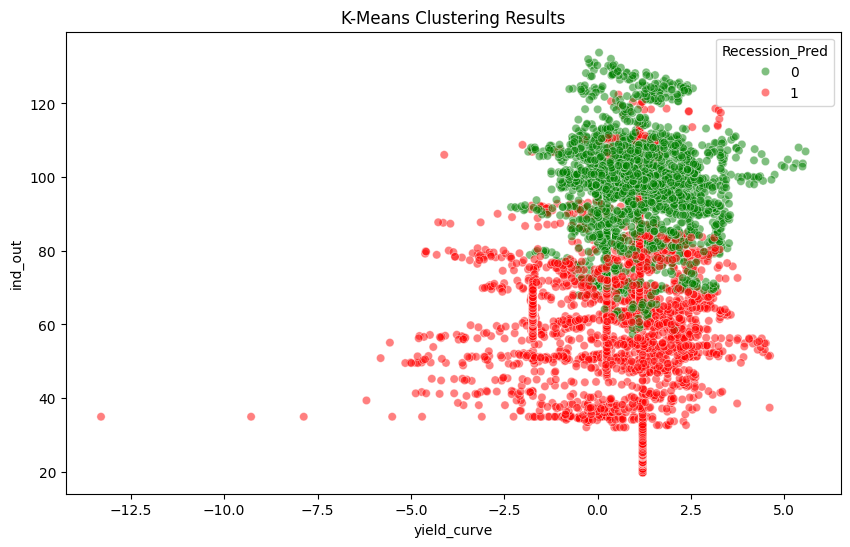

In [66]:
print("K-Means Clustering")

pref_km = ['10_yr_yld', '3_mo_yld', 'yield_curve', 'unemployment', 'ind_out', 'cpi', 'national_share_price']
feat_km = [c for c in pref_km if c in df_raw.columns]
    
if len(feat_km) >= 2:

        df_km = df_raw[['date', 'country', 'oecd_rec'] + feat_km].copy()
        df_km.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_km = impute_features(df_km, feat_km) 
        df_km = df_km.dropna()
        
        print(f"Fitting K-Means on {len(df_km)} samples with features: {feat_km}")
        
        scaler_km = StandardScaler()
        X_scaled_km = scaler_km.fit_transform(df_km[feat_km])
        
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        df_km['Cluster'] = kmeans.fit_predict(X_scaled_km)
        
        cluster_stats = df_km.groupby('Cluster')[feat_km].mean()
        if 'unemployment' in cluster_stats.columns:
            rec_cluster = cluster_stats['unemployment'].idxmax()
        elif 'ind_out' in cluster_stats.columns:
            rec_cluster = cluster_stats['ind_out'].idxmin()
        else:
            rec_cluster = 0
            
        print(f"Identified Cluster {rec_cluster} as 'Recession' Regime.")
        df_km['Recession_Pred'] = df_km['Cluster'].apply(lambda x: 1 if x == rec_cluster else 0)
        
        print(f"Global Accuracy: {accuracy_score(df_km['oecd_rec'], df_km['Recession_Pred']):.3f}")
        
        plot_cols = [c for c in feat_km if c in ['unemployment', 'ind_out', 'yield_curve']]
        if len(plot_cols) >= 2:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(data=df_km, x=plot_cols[0], y=plot_cols[1], hue='Recession_Pred', 
                            palette={0:'green', 1:'red'}, alpha=0.5)
            plt.title('K-Means Clustering Results')
            plt.show()
else:
        print("Not enough features for K-Means.")

## Deep Learning Experiment Long Short-term Memory (LSTM) 
- a neural network approach that captures sequential dependencies without manual feature lagging.

- Key Functions: This creates a "Sliding Window." The model tries to predict what happens in Month 15 based on the story told by Months 1-12.

In [64]:
if not df_raw.empty:
    print("Preparing data for LSTM (Per-Country Analysis)...")

    exclude_cols = ['date', 'country', 'target_3m', 'target_6m', 'year', 'oecd_rec', 'pre_recession']
    tier_1_concepts = ['10_yr_yld', '3_mo_yld', 'yield_curve', 'real_gdp', 'ind_out', 'retail_vol', 'pcar_reg', 'unemployment', 'sahm', 'cpi', 'oil', 'copper', 'national_share_price']
    
    tier_1_cols = get_feature_cols(df_raw, tier_1_concepts, exclude_cols)
    df_lstm = df_raw[['date', 'country', 'target_3m'] + tier_1_cols].copy()
    
    df_lstm.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_lstm = df_lstm.dropna(subset=['target_3m'])
    df_lstm['target_3m'] = df_lstm['target_3m'].astype(int)
    
    df_lstm = impute_features(df_lstm, tier_1_cols)
    df_lstm = df_lstm.dropna() 
    
    SPLIT_DATE = '2005-01-01'
    train_df = df_lstm[df_lstm['date'] < SPLIT_DATE].copy()
    test_df = df_lstm[df_lstm['date'] >= SPLIT_DATE].copy()

    scaler = MinMaxScaler()
    train_df[tier_1_cols] = scaler.fit_transform(train_df[tier_1_cols])
    test_df[tier_1_cols] = scaler.transform(test_df[tier_1_cols])

    TIME_STEPS = 12 
    
    print(f"Generating sequences (Look-back: {TIME_STEPS} months)...")
    X_train, y_train, _ = create_sequences(train_df, tier_1_cols, 'target_3m', TIME_STEPS)
    X_test, y_test, c_test = create_sequences(test_df, tier_1_cols, 'target_3m', TIME_STEPS)

    print(f"Train Shape: {X_train.shape} (Samples, Steps, Features)")
    print(f"Test Shape:  {X_test.shape}")

    neg = np.bincount(y_train)[0]
    pos = np.bincount(y_train)[1]
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    print(f"Class Weights: {class_weight}")

    tf.random.set_seed(42)
    model = Sequential([
        LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.3), 
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    print("\nTraining LSTM...")
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2, 
        class_weight=class_weight, 
        callbacks=[early_stop],
        verbose=0 
    )
    print("Training Complete.")

    y_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    results_df = pd.DataFrame({
        'country': c_test,
        'y_true': y_test,
        'y_pred': y_pred,
        'y_proba': y_prob
    })
    
    print_country_metrics(results_df)
else:
    print("Error: df_raw is empty.")

Preparing data for LSTM (Per-Country Analysis)...
Generating sequences (Look-back: 12 months)...
Train Shape: (3672, 12, 175) (Samples, Steps, Features)
Test Shape:  (1593, 12, 175)
Class Weights: {0: np.float64(0.8693181818181819), 1: np.float64(1.176923076923077)}

Training LSTM...
Training Complete.
             Accuracy  Precision    Recall        F1   ROC-AUC  Support
Country                                                                
Australia    0.638418   0.774194  0.296296  0.428571  0.490998       81
Canada       0.694915   0.689655  0.307692  0.425532  0.792308       65
France       0.689266   0.697674  0.674157  0.685714  0.775664       89
Germany      0.638418   0.741379  0.467391  0.573333  0.714578       92
Italy        0.757062   0.550000  0.673469  0.605505  0.824777       49
Japan        0.564972   0.595238  0.294118  0.393701  0.598721       85
South Korea  0.683616   0.566667  0.283333  0.377778  0.673077       60
UK           0.655367   0.246377  0.653846  0.35

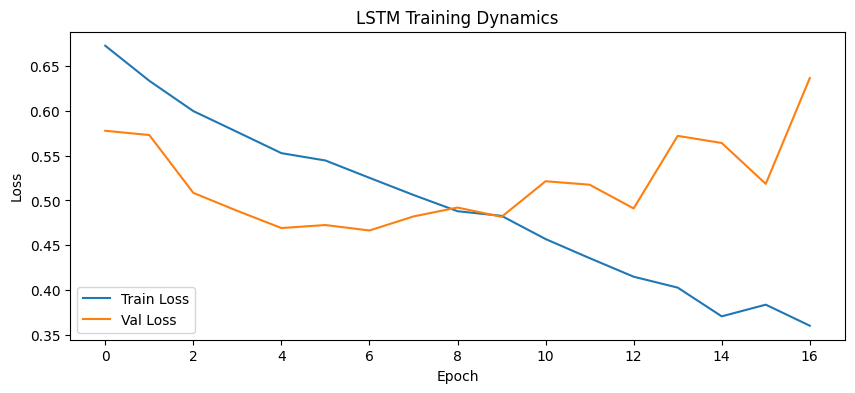

In [65]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Training Dynamics')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# Logistic Regression by Country and Time-series

- We have established that Logistic Regression is our baseline model. Now, instead of just testing it once globally, we are performing a deep-dive validation to ensure the model isn't just "getting lucky" on a few large countries or specific time periods.

Preparing Tier 1 data for per-country analysis...
Data Ready. Shape: (5292, 176)
Starting Cross-Validation (5 splits)...
             Accuracy  Precision    Recall        F1   ROC-AUC  Support
Country                                                                
Canada       0.768707   0.701031  0.635514  0.666667  0.826928      107
France       0.697279   0.873016  0.404412  0.552764  0.831627      272
Germany      0.729592   0.734127  0.667870  0.699433  0.809245      277
Italy        0.758503   0.711628  0.656652  0.683036  0.805271      233
Japan        0.741497   0.662116  0.785425  0.718519  0.805039      247
South Korea  0.600340   0.464029  0.600000  0.523327  0.665166      215
UK           0.678571   0.477912  0.668539  0.557377  0.756358      178
USA          0.799320   0.753846  0.784000  0.768627  0.867160      250

--------------------------------------------------------------------------------
Global Accuracy: 0.719
Global Recall:   0.649
Global F1 Score: 0.650
Global R

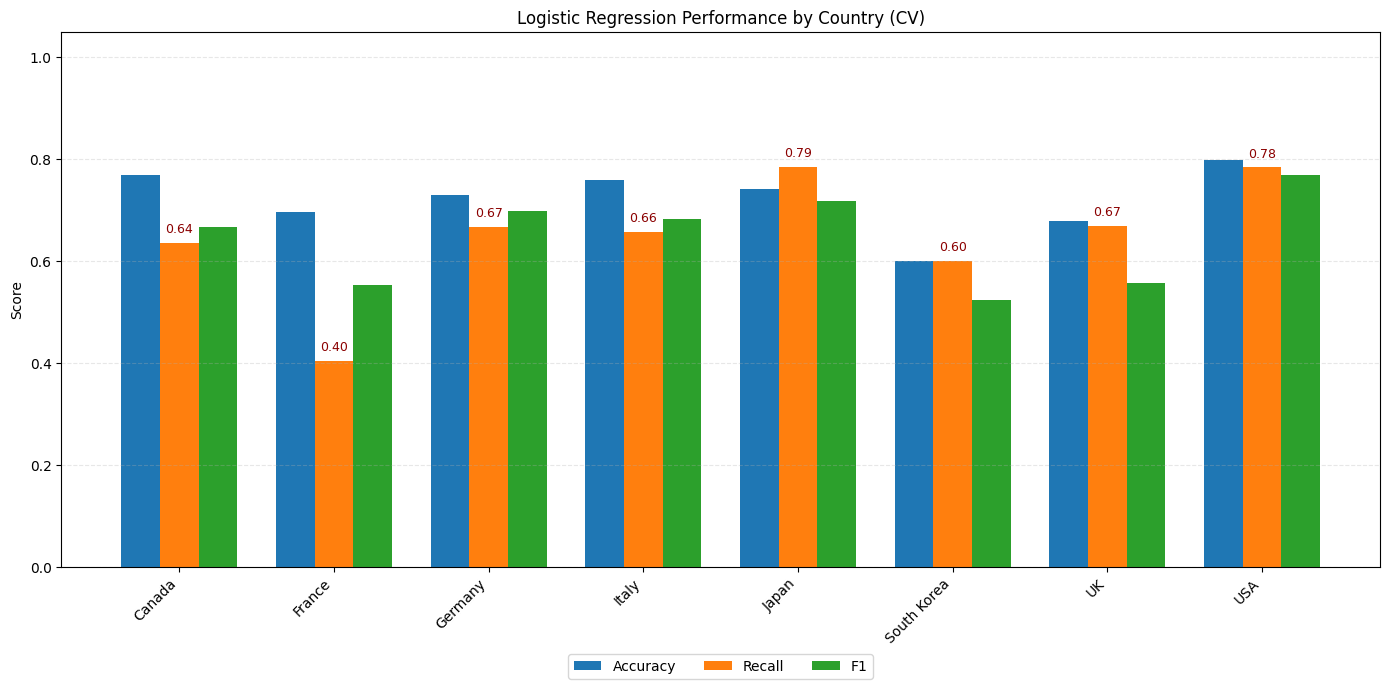

In [73]:
if not df_raw.empty:
    print("Preparing Tier 1 data for per-country analysis...")

    exclude_cols = ['date', 'country', 'target_3m', 'target_6m', 'year', 'oecd_rec', 'pre_recession', 'technical_rec', 'gdp_qoq_growth']
    tier_1_concepts = ['10_yr_yld', '3_mo_yld', 'yield_curve', 'real_gdp', 'ind_out', 'retail_vol', 'pcar_reg', 'unemployment', 'sahm', 'cpi', 'oil', 'copper', 'national_share_price']
    
    tier_1_cols = get_feature_cols(df_raw, tier_1_concepts, exclude_cols)

    df_lr = df_raw[df_raw['date'] < '2019-01-01'].copy()
    
    df_lr = df_lr[['date', 'country', 'target_3m'] + tier_1_cols]
    df_lr.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_lr = df_lr.dropna(subset=['target_3m'])
    df_lr['target_3m'] = df_lr['target_3m'].astype(int)
    
    df_lr = impute_features(df_lr, tier_1_cols)
    df_lr = df_lr.dropna()
    
    print(f"Data Ready. Shape: {df_lr.shape}")

    model_lr = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', class_weight='balanced', random_state=42)
    
    cv_results = run_cross_validation_analysis(
        X=df_lr[tier_1_cols], 
        y=df_lr['target_3m'], 
        countries=df_lr['country'], 
        model=model_lr, 
        n_splits=5
    )

    metrics_df = print_country_metrics(cv_results)

    fig, ax = plt.subplots(figsize=(14, 7))
    plot_metrics = ['Accuracy', 'Recall', 'F1']
    x = np.arange(len(metrics_df))
    width = 0.25
    
    for i, metric in enumerate(plot_metrics):
        ax.bar(x + i * width, metrics_df[metric], width, label=metric)

    ax.set_xticks(x + width)
    ax.set_xticklabels(metrics_df.index, rotation=45, ha='right')
    ax.set_ylabel('Score')
    ax.set_title('Logistic Regression Performance by Country (CV)')
    ax.set_ylim(0, 1.05)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    for i, val in enumerate(metrics_df['Recall']):
        ax.text(i + width, val + 0.02, f"{val:.2f}", ha='center', fontsize=9, color='darkred')

    plt.tight_layout()
    plt.show()

else:
    print("Error: df_raw is empty.")

## Inspecting 2019 Data - Ehhance XGboost Regression models

- The Problem: These labels are technically correct (2019 was before the 2020 recession), but the 2020 recession was caused by COVID-19, not by economic fundamentals.

- The Risk: If we train the model to think "2019 economic data = Recession coming," we are teaching it to hallucinate. The economy in 2019 was actually fine; the virus was the cause.

## Result compare:
- Previews output:
 ROC-AUC: 0.709,
 F1 Score: 0.518

- New output:
 ROC-AUC:  0.782,
 F1 Score: 0.663

In [71]:
if not df_raw.empty:
    print("Preparing Data for XGBoost (Tier 1 + Tier 2)...")

    exclude_cols = ['date', 'country', 'target_3m', 'target_6m', 'year', 'oecd_rec', 'pre_recession', 'technical_rec', 'gdp_qoq_growth']
    
    tier_1_concepts = ['10_yr_yld', '3_mo_yld', 'yield_curve', 'real_gdp', 'ind_out', 'retail_vol', 'pcar_reg', 'unemployment', 'sahm', 'cpi', 'oil', 'copper', 'national_share_price']
    tier_2_concepts = ['epu', 'vix', 'gps', 'cli', 'comp_consumer_conf']


    cols_t1 = get_feature_cols(df_raw, tier_1_concepts, exclude_cols)
    cols_t2 = get_feature_cols(df_raw, tier_2_concepts, exclude_cols, strict=True)
    feature_cols_xgb = list(set(cols_t1 + cols_t2))


    df_cv_xgb = df_raw[df_raw['date'] < '2019-01-01'].copy()
    
    df_cv_xgb = df_cv_xgb[['date', 'country', 'target_3m'] + feature_cols_xgb]
    df_cv_xgb.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_cv_xgb = df_cv_xgb.dropna(subset=['target_3m'])
    df_cv_xgb['target_3m'] = df_cv_xgb['target_3m'].astype(int)
    
    df_cv_xgb = impute_features(df_cv_xgb, cols_t1)
    
    df_cv_xgb = df_cv_xgb.dropna(subset=cols_t1)

    print(f"Data Prepared. Shape: {df_cv_xgb.shape}")
    print(f"Features: {len(feature_cols_xgb)} (Tier 1 & Tier 2)")

    neg, pos = np.bincount(df_cv_xgb['target_3m'])
    spw = neg / pos if pos > 0 else 1
    
    print(f"Calculated scale_pos_weight: {spw:.2f}")

    model_xgb = XGBClassifier(
        n_estimators=200, 
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=spw,
        missing=np.nan,            
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    cv_results_xgb = run_cross_validation_analysis(
        X=df_cv_xgb[feature_cols_xgb], 
        y=df_cv_xgb['target_3m'], 
        countries=df_cv_xgb['country'], 
        model=model_xgb, 
        n_splits=5
    )
    
    print_country_metrics(cv_results_xgb)

else:
    print("Error: df_raw is empty.")

Preparing Data for XGBoost (Tier 1 + Tier 2)...
Data Prepared. Shape: (5292, 230)
Features: 227 (Tier 1 & Tier 2)
Calculated scale_pos_weight: 1.45
Starting Cross-Validation (5 splits)...
             Accuracy  Precision    Recall        F1   ROC-AUC  Support
Country                                                                
Canada       0.639456   0.503650  0.644860  0.565574  0.691739      107
France       0.704082   0.760638  0.525735  0.621739  0.780959      272
Germany      0.693878   0.680297  0.660650  0.670330  0.780735      277
Italy        0.804422   0.721805  0.824034  0.769539  0.877169      233
Japan        0.753401   0.696154  0.732794  0.714004  0.786209      247
South Korea  0.568027   0.452323  0.860465  0.592949  0.707887      215
UK           0.668367   0.471380  0.786517  0.589474  0.811757      178
USA          0.801020   0.821256  0.680000  0.743982  0.893077      250

--------------------------------------------------------------------------------
Global Acc


Extracting Feature Importance (Full Pre-2019 Set)...

=== Top 10 Drivers (XGBoost) ===
                           Feature  Importance
203                   cli_diff_6mo    0.042864
101                  cli_diff_12mo    0.026765
162  yield_curve_inverted_lag_12mo    0.022447
110   yield_curve_inverted_lag_3mo    0.018428
66                    cli_diff_1mo    0.014768
27    yield_curve_inverted_lag_6mo    0.012129
44                             cli    0.011979
74                    cli_diff_3mo    0.010869
212   epu_rolling_mean_6mo_lag_1mo    0.009959
144           vix_rolling_mean_6mo    0.008057


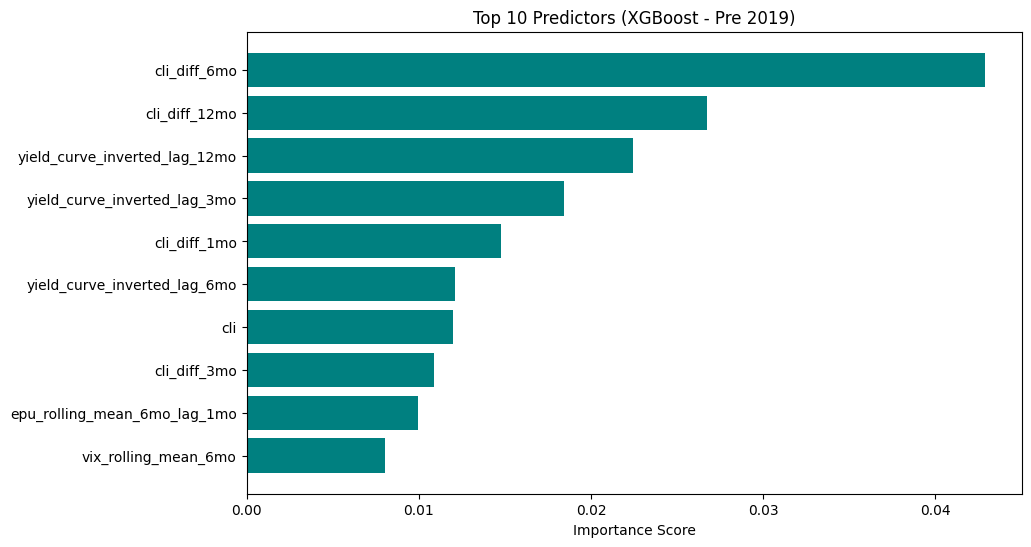

In [72]:

print("\nExtracting Feature Importance (Full Pre-2019 Set)...")
model_xgb.fit(df_cv_xgb[feature_cols_xgb], df_cv_xgb['target_3m'])
    
importance = pd.DataFrame({
        'Feature': feature_cols_xgb,
        'Importance': model_xgb.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    
print("\n=== Top 10 Drivers (XGBoost) ===")
print(importance)
    
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'], color='teal')
plt.gca().invert_yaxis()
plt.title("Top 10 Predictors (XGBoost - Pre 2019)")
plt.xlabel("Importance Score")
plt.show()